# LSS Diffusion Distortion

In [1]:
"""
    TITLE   : Calculating the Diffusion Distortions
    PROJECT : Cosmic Conchometer
""";

<span style='font-size:30px;font-weight:650'>
    About
</span>




<br><br>

- - - 


## Prepare

### Imports

In [2]:
# %matplotlib ipympl
%matplotlib inline

# THIRD PARTY
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import tqdm

import astropy.units as u
import astropy.constants as const
from astropy import cosmology
from classy import Class as CLASS

# PROJECT-SPECIFIC
import cosmic_conchometer as cc
from cosmic_conchometer.diffusion_distortion import SpectralDistortion, make_secondlast_scattering_integration_domain, fit_smooth_sP_on_grid
from cosmic_conchometer.utils import distances, classy_utils

## Parameters

### CLASS computations

In [3]:
# Create an instance of the CLASS wrapper
class_cosmo = CLASS()
# read and set parameters from file
params = classy_utils.read_params_from_ini("input/parameters.ini")
class_cosmo.set(params)
# Run the whole code.
class_cosmo.compute()

# thermodynamics
thermo = class_cosmo.get_thermodynamics()

### Astropy Cosmology

In [4]:
cosmology.default_cosmology.set("Planck18")
cosmo = cosmology.default_cosmology.get()
cosmo

FlatLambdaCDM(name="Planck18", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049)

<br><br>

- - - 


Make the spectral distortion class

In [5]:
sd = SpectralDistortion(cosmo, class_cosmo)

In [6]:
sd.lambda0

<Quantity 386.92729036 Mpc>

Plot the distribution of evaluation redshifts

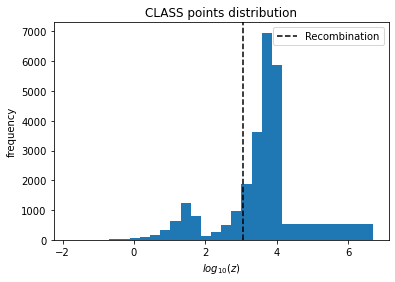

In [7]:
sd.plot_CLASS_points_distribution();
plt.show();

Choosing z_V

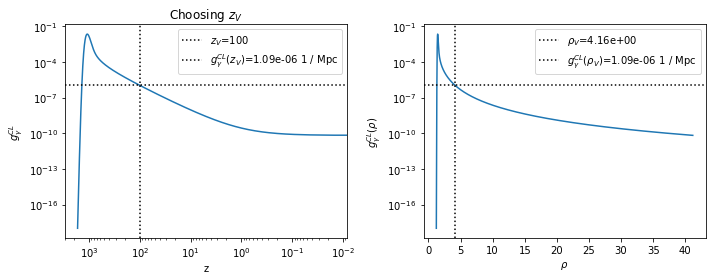

In [8]:
sd.plot_zv_choice()
plt.gcf().tight_layout()

plt.show();

sP Integrand

In [9]:
# fig, metadata = sd.plot_integrand_at(spll=1.8, sprp=0.1,
#                                      peakskw=dict(prominence=1e-6));
# fig.savefig("integrand_example.pdf", format="pdf")
# plt.show()

On a grid

In [10]:
splls = np.linspace(-3.5, 3.5, num=int((3.5 - (-3.5)) * 40) + 1)  # 281
sprps = np.power(np.e, np.linspace(-12, 1.25, num=int(3.5 * 40) + 1))  # 141

In [ ]:
# sd.calculate_sprpP_on_grid(splls, sprps)

In [12]:
saved = np.load(f"output/run-bounds_0.7073462974127513_7.15590079883689-epsabs_1Em11-limit_500.npz")

Splls, Sprps = saved["Splls"], saved["Sprps"]
results = saved["results"]
errors = saved["errors"]
relative_errors = saved["relative_errors"]
bounds = saved["bounds"]

results = results.reshape(Splls.shape)


results[results < 1e-4] = 0


In [13]:
# ax = sd.plot_sprpPspllsprp(Splls, Sprps, results, threshold=1e-4)
# plt.show()

Want to go to lower Sperp so we get values closer to 1e-4.
Want to go to higher resolution in Spll, so use this as a mask to define a quick check whether to perform the integral, or call it 0.

Making a mask

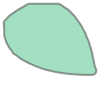

In [14]:
domain = make_secondlast_scattering_integration_domain(Splls, Sprps, results, threshold=1e-4, buffer=0.2)
domain

In [15]:
initialsplls = np.linspace(-3.5, 3.5,
                           num=int((3.5 - (-3.5)) * 40) + 1)  # 281
highdensitysppls = np.linspace(sd.maxrhovalid - 2, sd.maxrhovalid - 1.2, 100)
splls = np.concatenate((initialsplls[initialsplls < highdensitysppls[0]], 
                        highdensitysppls,
                        initialsplls[initialsplls > highdensitysppls[-1]]))

sprps = np.power(np.e, np.linspace(-23, 1.25, num=int(3.5 * 80) + 1))  # 281
# Sprps2, Splls2 = np.meshgrid(sprps, splls)
# Splls2.shape

In [16]:
# UNCOMMENT TO RUN 3 DAY CALCULATION
# sd.calculate_sprpP_on_grid(splls, sprps, domain=domain)

In [17]:
saved = np.load(f"output/run-bounds_(0.7073462974127513, 7.15590079883689)-integkw_dict_items([('epsabs', 1e-11), ('limit', 500)]).npz")

Splls = saved["Splls"]
Sprps = saved["Sprps"]
results = saved["results"]
errors = saved["errors"]
relative_errors = saved["relative_errors"]
bounds = saved["bounds"]

results = results.reshape(Splls.shape)

results = results.reshape(Splls.shape)
results[results < 1e-4] = 0

# %matplotlib inline
# ax = sd.plot_sprpPspllsprp(Splls, Sprps, results, threshold=1e-4)
# plt.show()

Interpolate:

When we interpolate, the threshold determines which values are taken to "0". But to prevent ringing, we actually set them
to be below the threshold by a factor of ``log10_d_clip``. It's important to not make that too low (ie. -infinity where we see ringing) but also not too high, where it contributes a lot of power at q||=0 and therefore also messes with the overall normalization.

<AxesSubplot:title={'center':'$s_{\\perp} P(s_{||}, s_{\\perp})$'}, xlabel='$\\rho_{valid}^{\\max} - s_{||}$', ylabel='$s_{\\perp}$'>

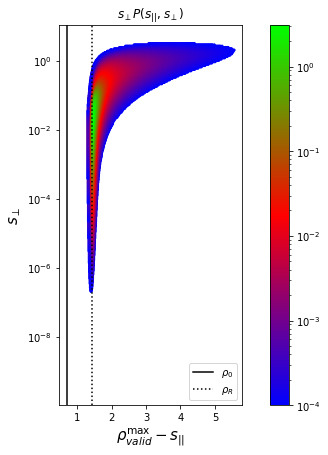

In [18]:
interp = fit_smooth_sP_on_grid(splls, sprps, results, threshold=1e-4, log10_d_clip=-4)  # introduces ringing
sd.plot_sprpPspllsprp(Splls, Sprps, interp, threshold=1e-4)

Super-sample.

In [19]:
%%time

splls2 = np.linspace(sd.maxrhovalid - 5, sd.maxrhovalid + 3, 2**11)
sprps2 = np.power(np.e, np.linspace(-17, 1.25, num=2**10))

Splls2, Sprps2 = np.meshgrid(splls2, sprps2, indexing="ij")

results2 = 10**interp(Splls2, np.log10(Sprps2), grid=False)

CPU times: user 1.06 s, sys: 36.4 ms, total: 1.09 s
Wall time: 1.13 s


<AxesSubplot:title={'center':'$s_{\\perp} P(s_{||}, s_{\\perp})$'}, xlabel='$\\rho_{valid}^{\\max} - s_{||}$', ylabel='$s_{\\perp}$'>

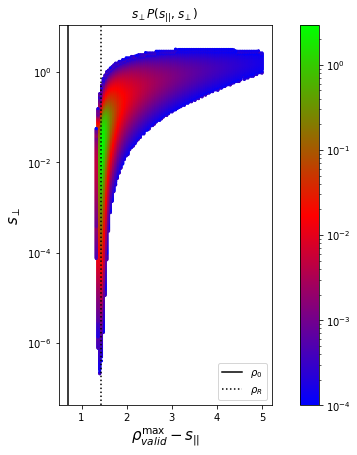

In [20]:
%matplotlib inline
plt.close("all")
sd.plot_sprpPspllsprp(Splls2[::10], Sprps2[::10], results2[::10])

In [301]:
# CHECKING PROBABILITY INTEGRATES TO 1
# FIXME!

spl = RectBivariateSpline(splls2, sprps2, Sprps2 * results2)
2 * np.pi * spl.integral(-10000, 10000, 0, 10000)

0.06386364900392287

- - -

## FFT

In [21]:
from cosmic_conchometer.diffusion_distortion import utils
from scipy.fft import fft, ifft, fftshift

In [22]:
%%time

qpll, qprp, Ptilde, resfft = utils.fft_sP(splls2, sprps2, results2, full_output=True)

CPU times: user 190 ms, sys: 99.9 ms, total: 290 ms
Wall time: 318 ms


In [23]:
Ptilde[1, 0] + Ptilde[-1, 0], Ptilde[1, 0] - Ptilde[-1, 0]

((7.11539359177765e-06+0j), 4.104487940262677e-06j)

<AxesSubplot:title={'center':'$s_{\\perp} P(s_{||}, s_{\\perp})$'}, xlabel='$\\rho_{valid}^{\\max} - s_{||}$', ylabel='$s_{\\perp}$'>

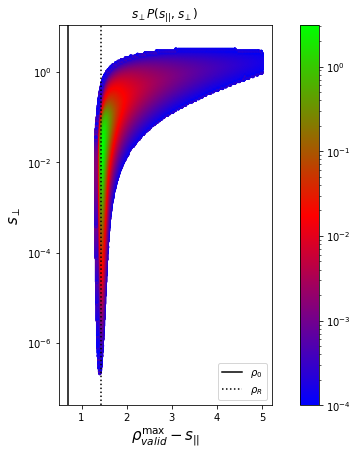

In [24]:
N = resfft.shape[0]
minspll = min(splls2)
deltaspll = max(splls2) - minspll

step = 1
sd.plot_sprpPspllsprp(Splls2[::step, ::step], Sprps2[::step, ::step],
                      ifft(fftshift(resfft * N / deltaspll * np.exp(1j * minspll * qpll[:, None]) / 2 / np.pi), axis=0).real[::step, ::step],
                      threshold=1e-4)
# plt.gcf().set_size_inches(5, 5)

In [280]:
%matplotlib ipympl

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111, xlabel=r"$q_{||}$", ylabel="value")

freq = qpll
i = 720
print(f"s_perp = {sprps2[i]}")
ax.plot(freq, resfft[:, i].real, c="tab:blue")
ax.plot(freq, resfft[:, i].imag, c="tab:orange")
ax.plot(freq, np.sqrt((resfft[:, i].conjugate()*resfft[:, i]).real), c="tab:green")

# # COMPARISON
# interp3 = fit_smooth_sP_on_grid(splls, sprps, results, threshold=1e-4, log10_d_clip=-2)  # TODO! show this isn't sensitive to choice of threshold
# results3 = 10**interp3(Splls2, np.log10(Sprps2), grid=False)
# qpll3, qprp3, Ptilde3, resfft3 = utils.fft_sP(splls2, sprps2, results3, full_output=True)
# ax.plot(freq, fftshift(np.sqrt(resfft3[:, i].real**2 + resfft3[:, i].imag**2)), c="tab:red", ls=":")

ax.axvline(0, c="k")
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

s_perp = 0.01567912263632557


In [279]:
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(111, xlabel=r"$q_{||}$ index", ylabel=r"$s_{\perp}$ index")
mat = ax.matshow(np.sqrt((resfft.conjugate()*resfft).real).T, origin="lower",
#                  norm=cm.SymLogNorm(linthresh=1e-6, base=10)
                )
plt.colorbar(mat, ax=ax)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [278]:
plt.close("all")

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(121, xlabel=r"$q_{||}$ index", ylabel=r"$q_{\perp}$ index", title="magnitude")
mag = np.sqrt(Ptilde.real**2 + Ptilde.imag**2).T
mat = ax.matshow(mag,
                 norm=cm.SymLogNorm(linthresh=1e-4, base=10),
                 origin="lower", cmap="nipy_spectral_r")
plt.colorbar(mat)
plt.gcf().set_size_inches(8, 3)


ax = fig.add_subplot(122, xlabel=r"$q_{||}$ index", ylabel=r"$q_{\perp}$ index", title="phase")
mask = mag < 1e-4
angle = np.angle(Ptilde).T
angle[angle >= 0] = 1
angle[angle < 0] = -1
angle[mask] = np.nan
mat = ax.matshow(angle,
                 origin="lower", cmap="nipy_spectral_r")
plt.colorbar(mat)
ax.set_xlim(1000 - 200, 1000+200)
ax.set_ylim(0, 400)
plt.gcf().set_size_inches(16, 6)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
%%time
# TO GET A NICE INTERPOLATION OF THE Magnitude^2

from scipy.interpolate import RectBivariateSpline

mag2 = (Ptilde.conjugate() * Ptilde).real  # it's already real
Ptilde_mag2_interp = RectBivariateSpline(qpll, qprp, mag2)
Ptilde_mag2_interp

CPU times: user 246 ms, sys: 21.2 ms, total: 267 ms
Wall time: 280 ms


In [52]:
%matplotlib ipympl

j = np.random.randint(len(qprp)) - 1
# j = 10
print(j)
plt.plot(qpll[1:-2], mag2[1:-2, j], marker=".", label="value", zorder=0)

x = qpll[1:-2] + np.diff(qpll[1:-1])/4
_interp = Ptilde_mag2_interp(x, qprp[j])
plt.scatter(x, _interp, s=10, label="interp", c="tab:orange")

# plt.xlim(-200, 200)
plt.legend()
plt.show()

943


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
# %%time

# # TO GET A NICE INTERPOLATION OF THE PHASE

# from scipy.interpolate import RectBivariateSpline
# from scipy.signal import find_peaks

# angle = np.angle(Ptilde)

# for j in range(angle.shape[1]):
#     locs, props = find_peaks(angle[:, j])
#     for i in locs:
#         n = np.floor((angle[i, j] - angle[i-1, j]) / (2 * np.pi))  # undoing the phase wrap
#         angle[i:, j] -= (2 * np.pi)

# Ptilde_phase_interp = RectBivariateSpline(qpll, qprp, angle)
# Ptilde_phase_interp

# # this interpolation is good
# # j = np.random.randint(len(qprp)) - 1
# # plt.plot(np.absolute(1 - Ptilde_phase_interp((qpll[1:-2] + np.diff(qpll[1:-1]), qprp[j]))[0:-1] / Ptilde[2:-2, j]))

# %matplotlib ipympl

# # j = np.random.randint(len(qprp)) - 1
# j = 10
# print(j)
# plt.plot(qpll[1:-2], angle[1:-2, j], marker=".", label="value", zorder=0)

# x = qpll[1:-2] + np.diff(qpll[1:-1])/4
# _interp = Ptilde_interp(x, qprp[j])
# plt.scatter(x, _interp, s=10, label="interp", c="tab:orange")

# # plt.xlim(-200, 200)
# plt.legend()
# plt.show()

In [31]:
# # invert the Ptilde transform and show recover the original function 

# N = resfft.shape[0]
# minspll = min(splls2)
# deltaspll = max(splls2) - minspll
# sd.plot_sprpPspllsprp(Splls2[::10, ::10], Sprps2[::10, ::10],
#                       ifft((Ptilde / )
#                            * N / deltaspll * np.exp(1j * minspll * qpll[:, None]) / 2 / np.pi, axis=0).real[::10, ::10],
#                       threshold=1e-4)
# # plt.gcf().set_size_inches(5, 5)

In [32]:
# %matplotlib ipympl

# fig = plt.figure(figsize=(4, 4))
# ax = fig.add_subplot(111, xlabel=r"$q_{||}$", ylabel=r"$q_{\perp}$")
# mat = ax.matshow(np.angle(fftshift(Ptilde, axes=0)).T,
#                  cmap="plasma", origin="lower")
# plt.colorbar(mat, ax=ax)

# Calculating the Signal

$A^{\mathcal{T}}$

In [41]:
# from cosmic_conchometer.initial_conditions import TemperatureFluctuationsFourierSpace, kmag_from_ns
# import astropy.units as u

# %%time
# kmag = kmag_from_ns(nx=200, ny=200, nz=200, step=1, Lbox=200 * u.Mpc)
# kmag.shape

# %%time
# Akfunc = TemperatureFluctuationsFourierSpace(kmag)

# %%time
# Ak = Akfunc()
# Ak.shape

# %%time
# indexarray = np.arange(Ak.size)
# indexarray.shape

# rng = np.random.default_rng()
# rng

# rng.shuffle(indexarray, axis=0)

# newAk = Ak.flat[indexarray]
# newAk.shape = Ak.shape

# %%time

# from cosmic_conchometer.boltzmann.husugiyama95 import TransferFunctionHuSugiyama1995Theta0

# Theta0 = TransferFunctionHuSugiyama1995Theta0(cosmo, a=1 / (1 + 1100),
#                                               As=1e-10 * np.exp(3.04) * u.K**2,
#                                               knum=int(1e5),
#                                               krange=(1e-4, 0.03, 10.0) / u.Mpc,
#                                               integ_kw=dict(limit=400, epsabs=2e-7, epsrel=5e-29),
#                                               lgkwindow=0.1)

# Theta0.plot_theta0hat(fit=True, s=1)

# # k = (10**lgk) / u.Mpc
# # plt.plot(k, Theta0._signk(lgk) / 100)

# plt.axhline(0, c="k")
# plt.axvline(Theta0._kcross.value)
# plt.show();

# ATk = Ak * Theta0(kmag)

# %matplotlib ipympl

# plt.plot(kmag[201, 201, :], Theta0(kmag[201, 201, :]), ls="-", marker=".")
# # plt.plot(kmag[150, 150, :], Theta0(kmag[150, 150, :]))
# # plt.plot(kmag[0, 0, :], Theta0(kmag[0, 0, :]))
# plt.show()

## Eq 64

Solving with Fourier Transforms

In [103]:
%%time

from cosmic_conchometer.boltzmann.husugiyama95 import TransferFunctionHuSugiyama1995Theta0
from scipy.interpolate import Akima1DInterpolator  # PchipInterpolator

Theta0 = TransferFunctionHuSugiyama1995Theta0(cosmo, a=1 / (1 + 1100),
                                              As=1e-10 * np.exp(3.04) * u.K**2,
                                              knum=int(1e5),
                                              krange=(1e-4, 0.03, 10.0) / u.Mpc,
                                              integ_kw=dict(limit=400, epsabs=2e-7, epsrel=5e-29),
                                              lgkwindow=0.1,
                                              _interp_fn=Akima1DInterpolator)

CPU times: user 7.36 s, sys: 165 ms, total: 7.52 s
Wall time: 7.65 s


In [262]:
def power_spectrum(kmag: u.Quantity, *, As: u.Quantity, ns: float,
                   pivot_scale: u.Quantity) -> np.ndarray:
    """Power spectrum, with :math:`A_s` factored out.

    Parameters
    ----------
    kmag : (N, M, L) Quantity
        Meshgrid (indexing = "ij") of :math:`|k|`.
        Units of inverse distance.
    As : Quantity, optional keyword-only
        Scalar amplitude. See Planck paper [1]_. Units of temperature squared.
    ns : float, optional keyword-only
        Scalar spectral index. See Planck paper [1]_.
    pivot_scale : |Quantity|, optional keyword-only
        The scale at which ``ns`` is normalized. See Planck paper [1]_.
    """
    Pk = np.power((kmag / pivot_scale).to_value(u.one), ns - 1)
    return Pk

In [313]:
PTT_qpll = np.logspace(0.003, 3, num=1000, base=10, dtype=np.float128) # qpll
PTT_qprp = np.logspace(0.002, 3, num=1000, base=10, dtype=np.float128) # qprp

qmag = np.sqrt(PTT_qpll[:, None]**2 + PTT_qprp[None, :]**2)

# Convert to K
kpll = PTT_qpll / sd.lambda0
kprp = PTT_qprp / sd.lambda0
kmag = qmag / sd.lambda0

if np.any(kmag > 10 / u.Mpc):
    raise ValueError
else:
    too_big = np.zeros_like(qmag, dtype=bool)

/Users/nathanielstarkman/miniconda/envs/cosmo/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  func(*args, **kwargs)
/Users/nathanielstarkman/miniconda/envs/cosmo/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


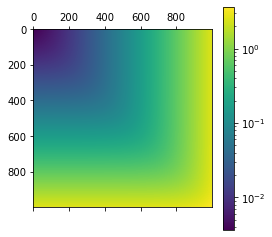

In [265]:
plt.matshow(kmag.value.T, norm=cm.LogNorm())
plt.colorbar()

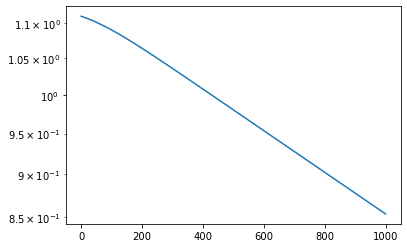

In [266]:
%matplotlib inline

plt.plot(power_spectrum(kmag[0, :], As = 1e-10 * np.exp(3.04) * u.K**2,
                           ns = 0.96, pivot_scale = 0.05 / u.Mpc))
plt.yscale("log")

In [267]:
%%time

th02 = np.full_like(qmag, np.nan)
th02[~too_big] = Theta0(kmag[~too_big])**2

Pk = np.full_like(qmag, np.nan)
PTT = np.full_like(qmag, np.nan)

Pk[~too_big] = power_spectrum(kmag[~too_big], As = 1e-10 * np.exp(3.04) * u.K**2,
                              ns = 0.96, pivot_scale = 0.05 / u.Mpc)


PTT[~too_big] = Pk[~too_big] * th02[~too_big]
PTT

CPU times: user 340 ms, sys: 76 ms, total: 416 ms
Wall time: 445 ms


array([[8.26186750e+00, 8.09099924e+00, 7.92197170e+00, ...,
        9.48766956e-11, 2.95813496e-10, 3.25651711e-10],
       [8.09027717e+00, 7.92355878e+00, 7.75861447e+00, ...,
        9.48758599e-11, 2.95812830e-10, 3.25652061e-10],
       [7.92055391e+00, 7.75791821e+00, 7.59699179e+00, ...,
        9.48750125e-11, 2.95812156e-10, 3.25652416e-10],
       ...,
       [9.43460402e-11, 9.43452095e-11, 9.43443672e-11, ...,
        7.97202514e-11, 2.11411727e-11, 4.61180783e-11],
       [2.95599046e-10, 2.95598382e-10, 2.95597710e-10, ...,
        2.10981183e-11, 4.82657045e-11, 5.49276331e-11],
       [3.25651596e-10, 3.25651944e-10, 3.25652297e-10, ...,
        4.62181738e-11, 5.48803829e-11, 1.35676743e-11]], dtype=float128)

In [317]:
PTT_interp = RectBivariateSpline(kpll, kprp, PTT)  # it's univariate b/c only kprp, but this is convenient

In [318]:
# %%time

def integrand(kprp, kpll):
    return kprp * PTT_interp(kprp, kpll) * (1 - Ptilde_mag2_interp(kprp, kpll))

In [319]:
from scipy.integrate import dblquad

dblquad(integrand, -100, 100, -100, 100)

(-4126899.145068522, 0.02533305762335658)

## Eq 44

$T(\hat{n}) = T_0 \! + \! \int d^3{k} \tilde{\mathcal{P}}_{\hat{n}}(R(\hat{n})\vec{k})A^{\cal T}(\vec{k}) e^{id(z_V)\vec{k}\cdot\hat{n}}$

<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>